In [1]:
print("bobnet debug")

bobnet debug


In [2]:
from fetch_it import mnist

x_train,y_train, x_test,y_test = mnist()

In [3]:
import numpy as np
from frame import layer_init

In [4]:
def forward_backward(x,y,l1,l2):
    """forward pass is good"""
    f_l1 = x@l1 # (1,128)
    f_re = np.maximum(f_l1,0)
    f_l2 = f_re@l2 # (1,10)

    # backward
    out = np.zeros((len(y),10),np.float32)
    out[range(out.shape[0]),y] = 1

    # from pytorch: loss(x,class) = -x[class] + log(exp(x[j]).sum(), j belongs to class)
    los = (-f_l2 + np.log(np.exp(f_l2).sum(axis=1)).reshape((-1,1)))
    loss = (out*los).mean(axis=1)

    d_out = -out/len(y)
    grads = d_out - np.exp(-los)*d_out.sum(axis=1).reshape((-1,1))

    d_l2 = f_re.T.dot(grads)

    #dx_relu = grads.dot(l2.T)

    dx_l1 = (f_re > 0).astype(np.float32) * (grads.dot(l2.T))

    d_l1 = x.T.dot(dx_l1)

    return loss, d_l1, d_l2 

In [5]:
from tqdm import tqdm
import time

np.random.seed(1337)

l1 = layer_init(784,128)
l2 = layer_init(128,10)

losses = []
learning_rate = 1e-3
batch_size = 32

start = time.time()
for _ in tqdm(range(1000)):
    samp = np.random.randint(0,x_train.shape[0],size=(batch_size))
    X = x_train[samp].reshape((-1,28**2))
    Y = y_train[samp]
    loss, d_l1, d_l2 = forward_backward(X,Y,l1,l2)
    l1 -= learning_rate * d_l1
    l2 -= learning_rate * d_l2

    losses.append(loss.mean())
end = time.time()
print("time consumption: %.3f"%(end-start),end="")

100%|██████████| 1000/1000 [00:00<00:00, 2382.49it/s]

time consumption: 0.431

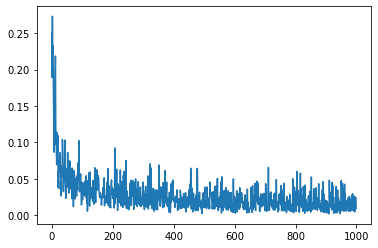

In [6]:
import matplotlib.pyplot as plt
losses[-1]
plt.plot(losses)

In [7]:
cat = np.maximum((x_test[0].reshape((-1,28**2)) @ l1),0) @ l2
(cat.argmax() == y_test[0]).astype(np.float32)

1.0

In [8]:
def evalu(l1,l2):
    accuracies = []
    for _ in tqdm(range(1000)):
        samp = np.random.randint(0,x_test.shape[0])
        X = x_test[samp]
        Y = y_test[samp]
        cat = np.maximum((X.reshape((-1,28**2)) @ l1),0) @ l2
        accu = (cat.argmax() == Y).astype(np.float32).sum()
        accuracies.append(accu)

    print("accuracies: %.2f"% (sum(accuracies)/len(accuracies)))

evalu(l1,l2)

100%|██████████| 1000/1000 [00:00<00:00, 25250.62it/s]

accuracies: 0.95


In [64]:
"""Do it w/ the right shape"""

def f_b_r(x,y,l1,l2):
    x = x.reshape((28*28,-1)) # (784, bs)
    f_l1 = l1.T @ x # (128, bs)
    f_re = np.maximum(f_l1,0)
    f_l2 = l2.T @ f_re # (10,bs)
    
    out = np.zeros((10,len(y))) # (10,bs)
    out[y,range(len(y))] = 1 # done

    # CE loss from pytorch: loss(x,class) = -x[class] + log(exp(x[j]).sum(), j belongs to class)
    # scalar

    loce = -f_l2 + np.log(np.exp(f_l2).sum(axis=0)) # (10,bs)

    """stability hack works but it's noisy"""
    #loce = (-f_l2 + np.log(np.exp(f_l2-f_l2.max()).sum(axis=0)))
    loss = (out*loce).mean(axis=0) # (bs,)

    """weird '-loce' right there"""
    grad = (-out.T/10 + (np.exp(-loce)*out.mean(axis=0)).T).T
    
    d_l2 = grad @ (f_re.T)
    d_l1 = ((f_re > 0).astype(np.float32)*(l2 @ grad)) @ (x.T)

    return loss, d_l1.T, d_l2.T


np.random.seed(1337)

l1 = layer_init(784,128)
l2 = layer_init(128,10)

bs = 1
lr = 1e-4
loss, d_l1, d_l2 = f_b_r(x_train[0:bs],y_train[0:bs],l1,l2)
losses = []
start = time.time()
for _ in tqdm(range(5000)):
    samp = np.random.randint(0,x_train.shape[0]-bs,size=(bs))
    loss, d_l1, d_l2 = f_b_r(x_train[samp],y_train[samp],l1,l2)
    l1 -= lr*d_l1
    l2 -= lr*d_l2
    losses.append(loss.mean())
end = time.time()
print("time consumption: %.3f"%(end-start))

100%|██████████| 5000/5000 [00:03<00:00, 1260.13it/s]

time consumption: 3.970


0.00024166107177734376

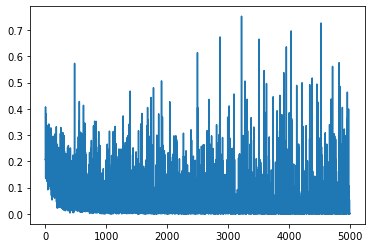

In [65]:
plt.plot(losses)
losses[-1]

In [66]:
print("right shape",end="")
evalu(l1,l2)

100%|██████████| 1000/1000 [00:00<00:00, 18678.13it/s]

right shapeaccuracies: 0.89
